### Задание
##### Преподаватель: Даниил Корбут, Наталья Баданина, Александр Миленькин, Анастасия Успенская
#### Взять с прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA.
#### Оценить качество и прислать соображения почему была выбрана та или иная модель

In [304]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [14]:
airlines_passengers = pd.read_csv("D:/DATA_SCIENCE/DZ/tsml-2/Series/international-airline-passengers.csv")

In [319]:
all_series = {   
    "Airline passengers": airlines_passengers["Count"],
    "Airline passengers Stat": airlines_passengers["Count"],
}

In [306]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [307]:
def tsplot(y, k, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title((k + " " +'Original'))

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        
    return plt.tight_layout()

##### Приводим модель к стационарному виду

Results of Dickey-Fuller Test:
Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


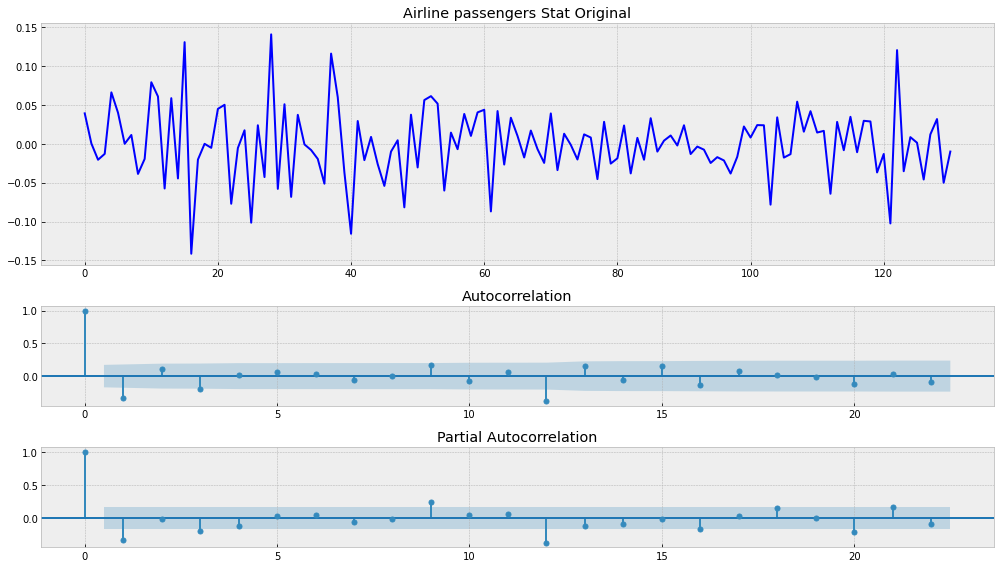

In [320]:
series = boxcox(all_series['Airline passengers Stat'], 0) #Убираем дисперсию
series = series[1:] - series[:-1] # Удаляем тренд
series = series[12:] - series[:-12] #Удаляем сезонность
all_series['Airline passengers Stat']=pd.Series(series) 
tsplot(series, 'Airline passengers Stat')

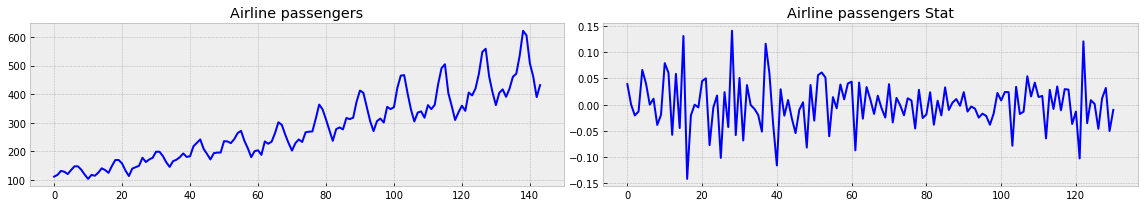

In [310]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)        
        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)        
    plt.tight_layout()

Так как оригинальный ряд имеет тренд и сезонность применим к нему
тройное экспоненциальное сглаживание - Метод Хольта-Винтерса (TEMA)

In [20]:
# def initial_trend(series, season_len):
#     return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [322]:
def initial_trend(series, slen):
    sum = 0.0
    for i in range(slen):
        sum += float(series[i+slen] - series[i]) / slen
    return sum / slen

In [323]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [324]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [325]:
def plot_tema(alpha, beta, gamma, ser=all_series["Airline passengers"], ser_to_plot=all_series["Airline passengers"], n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

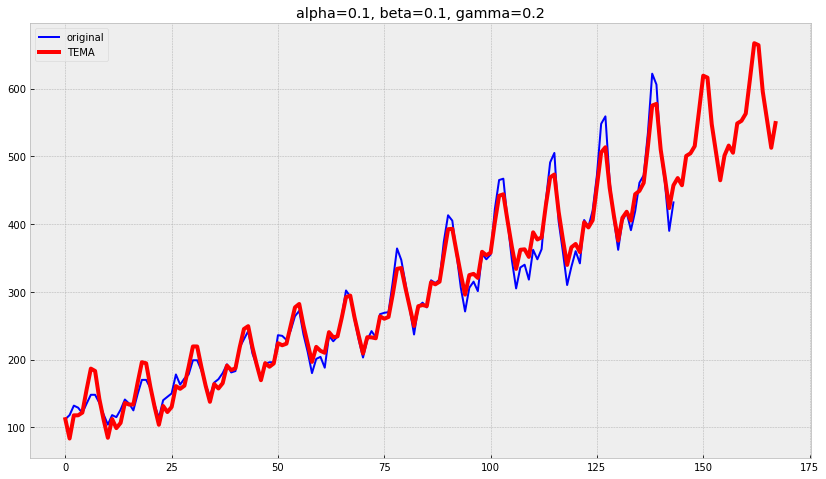

In [326]:
plot_tema(0.1, 0.1, 0.2)

##### Оптимизируем параметры модели ТЕМА:
* Алгоритм - градиентный спуск
* Критерий - min RMSE

In [327]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [328]:
series = all_series["Airline passengers"]

In [329]:
train, test, val = series[:60], series[60:70], series[70:]

In [342]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [343]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [344]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 209.06959559145167
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-7.95807864e-05, -5.68434189e-06,  4.15581752e+02])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 156
      nit: 31
     njev: 39
   status: 0
  success: True
        x: array([0.14851623, 0.03643977, 0.        ])


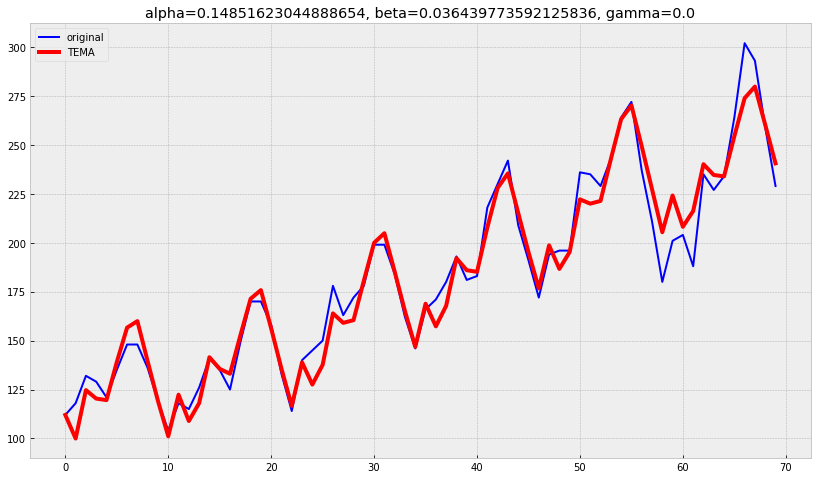

In [345]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series[:70], n_preds=len(test))

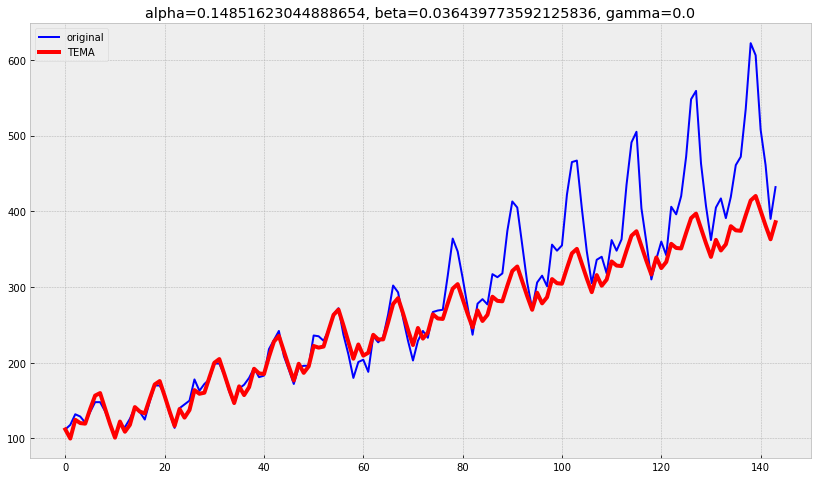

In [346]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=series[:70], ser_to_plot=series, n_preds=len(val))

##### Стационарная модель не имеет сезонности и тренда, но имеет выбросы.
##### Применим экпоненциальное сглаживание (EMA)

In [335]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [369]:
series1 = all_series["Airline passengers Stat"]

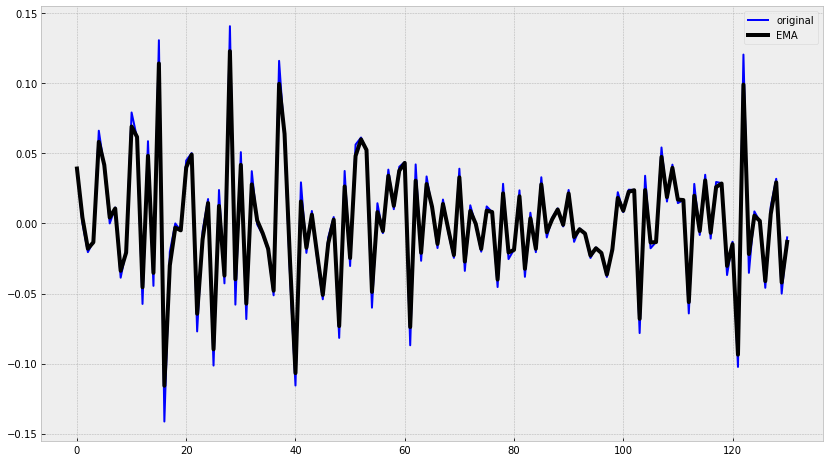

In [341]:
ema = exponential_smoothing(series1, 0.9)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series1, color='blue',label='original')
    plt.plot(ema, color='black', linewidth='4', label='EMA')
    plt.legend()

##### Оптимизируем параметры модели ЕМА:
* Алгоритм - градиентный спуск
* Критерий - min RMSE

In [370]:
train1, test1 = series1[:70], series1[70:]

In [354]:
def mse_ema(X):
    alpha, beta = X
    result = exponential_smoothing(train, alpha)
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [375]:
def plot_ema(alpha, ser=series1, ser_to_plot=series1):
    dema = exponential_smoothing(ser, alpha)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(ema, color='red', linewidth='4', label='EMA')
        plt.title("alpha={}".format(alpha))
        plt.legend()

In [376]:
opt = minimize(mse_ema, x0=[0, 0], method="L-BFGS-B", bounds = ((0, 1), (0, 1)))

In [378]:
alpha_opt= opt.x
print(opt)

      fun: 987.3175515125288
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.00010232, 0.        ])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 33
      nit: 5
     njev: 11
   status: 0
  success: True
        x: array([0.30209175, 0.        ])


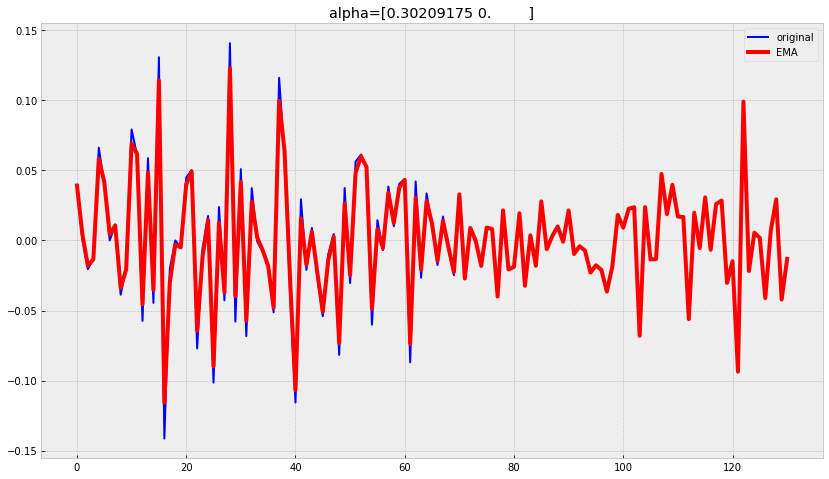

In [379]:
plot_ema(alpha_opt, ser=train1[:70], ser_to_plot=series1[:70])

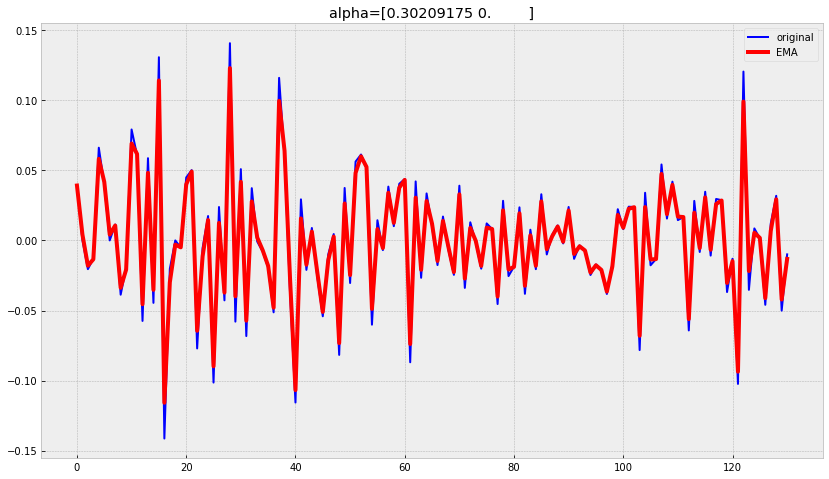

In [380]:
plot_ema(alpha_opt, ser=series1[:70], ser_to_plot=series1)